In [83]:
from matplotlib import pyplot as plt
import optuna
import time
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import random_split

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [45]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [46]:
dataset_path = "/Users/ludovicbribaud/Projet Garbage/Test/Garbage classification"

dataset = datasets.ImageFolder(root=dataset_path, transform=image_transforms)
len(dataset)

2527

In [47]:
dataset.classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [85]:
class_names = dataset.classes
class_names 

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [48]:
num_classes = len(dataset.classes)
num_classes

6

In [49]:
train_size = int(0.75*len(dataset))
val_size = len(dataset) - train_size

train_size, val_size

(1895, 632)

In [50]:
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [51]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [52]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [53]:
labels[0]

tensor(3)

In [54]:
images[0].shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<function matplotlib.pyplot.show(close=None, block=None)>

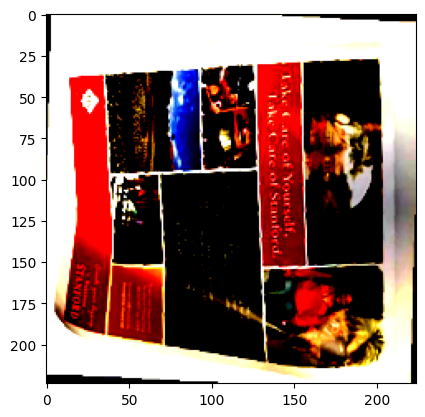

In [55]:
plt.imshow(images[0].permute(1,2,0))
plt.show

In [56]:
class GarbageClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(

            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding =1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.network(x)
        return x
        

In [57]:
model = GarbageClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [58]:
def train_model(model, criterion, optimizer, epochs=3):
    start = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            if (batch_num+1) % 10 == 0:
                print(f"Batch [{batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item(): 0.2f}")

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss: 4f}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data,1)
                total +=labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
            print(f"*** Validation Accuracy: {100 * correct / total: .2f}% ***")
            
    end = time.time()
    print(f"Execution time: {end - start} seconds")
    
    return all_labels, all_predictions

    

In [59]:
all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=3)

Batch [10, Epoch: 1, Loss:  1.52
Batch [20, Epoch: 1, Loss:  1.63
Batch [30, Epoch: 1, Loss:  1.60
Batch [40, Epoch: 1, Loss:  1.52
Batch [50, Epoch: 1, Loss:  1.17
Batch [60, Epoch: 1, Loss:  1.83
Epoch [1/3], Avg Loss:  1.578190
*** Validation Accuracy:  51.74% ***
Batch [10, Epoch: 2, Loss:  1.13
Batch [20, Epoch: 2, Loss:  1.01
Batch [30, Epoch: 2, Loss:  1.52
Batch [40, Epoch: 2, Loss:  1.40
Batch [50, Epoch: 2, Loss:  1.48
Batch [60, Epoch: 2, Loss:  1.10
Epoch [2/3], Avg Loss:  1.227695
*** Validation Accuracy:  53.48% ***
Batch [10, Epoch: 3, Loss:  0.98
Batch [20, Epoch: 3, Loss:  0.74
Batch [30, Epoch: 3, Loss:  1.47
Batch [40, Epoch: 3, Loss:  0.86
Batch [50, Epoch: 3, Loss:  1.40
Batch [60, Epoch: 3, Loss:  2.20
Epoch [3/3], Avg Loss:  1.090772
*** Validation Accuracy:  62.66% ***
Execution time: 573.5399580001831 seconds


In [63]:
class GarbageClassifierCNNWithRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding =1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.network(x)
        return x
        

In [64]:
model = GarbageClassifierCNNWithRegularization(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay = 1e-4)

In [65]:
train_model(model, criterion, optimizer, epochs=3)

Batch [10, Epoch: 1, Loss:  9.89
Batch [20, Epoch: 1, Loss:  5.04
Batch [30, Epoch: 1, Loss:  1.79
Batch [40, Epoch: 1, Loss:  1.64
Batch [50, Epoch: 1, Loss:  1.53
Batch [60, Epoch: 1, Loss:  1.36
Epoch [1/3], Avg Loss:  5.344220
*** Validation Accuracy:  42.09% ***
Batch [10, Epoch: 2, Loss:  1.57
Batch [20, Epoch: 2, Loss:  1.55
Batch [30, Epoch: 2, Loss:  1.39
Batch [40, Epoch: 2, Loss:  1.70
Batch [50, Epoch: 2, Loss:  1.82
Batch [60, Epoch: 2, Loss:  1.16
Epoch [2/3], Avg Loss:  1.549629
*** Validation Accuracy:  42.56% ***
Batch [10, Epoch: 3, Loss:  1.59
Batch [20, Epoch: 3, Loss:  1.42
Batch [30, Epoch: 3, Loss:  1.52
Batch [40, Epoch: 3, Loss:  1.52
Batch [50, Epoch: 3, Loss:  1.62
Batch [60, Epoch: 3, Loss:  1.97
Epoch [3/3], Avg Loss:  1.523157
*** Validation Accuracy:  45.25% ***
Execution time: 592.1290817260742 seconds


([2,
  0,
  2,
  1,
  3,
  3,
  2,
  4,
  1,
  4,
  3,
  0,
  4,
  2,
  1,
  3,
  4,
  4,
  1,
  0,
  4,
  3,
  4,
  3,
  4,
  1,
  0,
  3,
  3,
  1,
  0,
  1,
  1,
  3,
  3,
  0,
  0,
  3,
  2,
  4,
  4,
  2,
  4,
  4,
  4,
  4,
  0,
  1,
  3,
  3,
  1,
  4,
  1,
  4,
  0,
  5,
  3,
  3,
  3,
  4,
  0,
  3,
  3,
  3,
  4,
  1,
  4,
  1,
  2,
  1,
  2,
  3,
  5,
  4,
  1,
  0,
  2,
  3,
  3,
  4,
  2,
  0,
  4,
  3,
  1,
  0,
  4,
  2,
  3,
  4,
  4,
  0,
  2,
  3,
  3,
  0,
  3,
  2,
  0,
  4,
  3,
  5,
  0,
  3,
  1,
  2,
  5,
  2,
  2,
  1,
  0,
  0,
  3,
  0,
  3,
  2,
  4,
  2,
  0,
  3,
  3,
  2,
  0,
  4,
  0,
  1,
  0,
  0,
  3,
  3,
  0,
  1,
  1,
  1,
  3,
  4,
  1,
  3,
  2,
  2,
  3,
  3,
  0,
  0,
  1,
  3,
  3,
  3,
  1,
  0,
  4,
  4,
  3,
  4,
  3,
  3,
  4,
  2,
  4,
  4,
  0,
  0,
  3,
  0,
  0,
  3,
  2,
  0,
  0,
  3,
  0,
  1,
  0,
  0,
  0,
  2,
  0,
  1,
  4,
  2,
  4,
  0,
  5,
  1,
  2,
  1,
  1,
  3,
  3,
  3,
  3,
  4,
  2,
  3,
  4,
  0,
  3,
  0,
  0,
  2,


In [67]:
model = models.efficientnet_b0(weights='DEFAULT')
model.classifier[1].in_features

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /Users/ludovicbribaud/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|███████████████████████████████████████| 20.5M/20.5M [00:56<00:00, 381kB/s]


1280

In [72]:
class GarbageClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')

        for param in self.model.parameters():
            param.requires_grad = False
            
        in_features = self.model.classifier[1].in_features

        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x 

In [73]:
model = GarbageClassifierEfficientNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = 0.001)

In [74]:
train_model(model, criterion, optimizer, epochs=3)

Batch [10, Epoch: 1, Loss:  1.55
Batch [20, Epoch: 1, Loss:  1.42
Batch [30, Epoch: 1, Loss:  1.24
Batch [40, Epoch: 1, Loss:  0.98
Batch [50, Epoch: 1, Loss:  1.05
Batch [60, Epoch: 1, Loss:  1.06
Epoch [1/3], Avg Loss:  1.341954
*** Validation Accuracy:  74.84% ***
Batch [10, Epoch: 2, Loss:  0.92
Batch [20, Epoch: 2, Loss:  0.94
Batch [30, Epoch: 2, Loss:  0.85
Batch [40, Epoch: 2, Loss:  0.73
Batch [50, Epoch: 2, Loss:  0.84
Batch [60, Epoch: 2, Loss:  1.63
Epoch [2/3], Avg Loss:  0.931885
*** Validation Accuracy:  79.43% ***
Batch [10, Epoch: 3, Loss:  0.81
Batch [20, Epoch: 3, Loss:  0.89
Batch [30, Epoch: 3, Loss:  0.67
Batch [40, Epoch: 3, Loss:  0.80
Batch [50, Epoch: 3, Loss:  0.89
Batch [60, Epoch: 3, Loss:  0.69
Epoch [3/3], Avg Loss:  0.790093
*** Validation Accuracy:  80.38% ***
Execution time: 778.7648530006409 seconds


([0,
  3,
  2,
  1,
  1,
  3,
  2,
  4,
  3,
  3,
  1,
  4,
  0,
  4,
  4,
  0,
  2,
  0,
  3,
  1,
  0,
  1,
  1,
  3,
  1,
  4,
  1,
  0,
  1,
  0,
  3,
  0,
  3,
  1,
  4,
  2,
  4,
  1,
  3,
  0,
  3,
  4,
  2,
  2,
  0,
  0,
  2,
  0,
  1,
  2,
  2,
  1,
  2,
  1,
  3,
  2,
  1,
  2,
  3,
  2,
  4,
  3,
  1,
  4,
  2,
  4,
  0,
  1,
  0,
  3,
  4,
  2,
  3,
  0,
  1,
  2,
  4,
  4,
  3,
  0,
  1,
  0,
  1,
  3,
  0,
  4,
  1,
  3,
  0,
  0,
  1,
  4,
  2,
  0,
  5,
  1,
  4,
  5,
  2,
  3,
  3,
  3,
  3,
  1,
  3,
  3,
  1,
  3,
  3,
  2,
  4,
  0,
  2,
  1,
  3,
  4,
  1,
  1,
  1,
  3,
  2,
  5,
  1,
  1,
  3,
  3,
  1,
  4,
  0,
  1,
  2,
  4,
  3,
  2,
  0,
  1,
  3,
  2,
  2,
  3,
  5,
  2,
  4,
  5,
  3,
  1,
  3,
  3,
  4,
  5,
  3,
  1,
  3,
  3,
  0,
  1,
  1,
  3,
  4,
  0,
  5,
  4,
  3,
  1,
  2,
  4,
  4,
  0,
  4,
  0,
  3,
  3,
  4,
  3,
  4,
  4,
  0,
  2,
  3,
  1,
  3,
  1,
  5,
  5,
  1,
  3,
  3,
  0,
  2,
  2,
  2,
  3,
  0,
  0,
  5,
  1,
  3,
  3,
  3,
  3,


In [75]:
class GarbageClassifierRestNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')

        for param in self.model.parameters():
            param.requires_grad = False
            
        for param in self.model.layer4.parameters():
            param.requires_grad = True

        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x 

In [76]:
model = GarbageClassifierRestNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = 0.001)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/ludovicbribaud/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|███████████████████████████████████████| 97.8M/97.8M [02:59<00:00, 572kB/s]


In [77]:
all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=2)

Batch [10, Epoch: 1, Loss:  0.84
Batch [20, Epoch: 1, Loss:  0.51
Batch [30, Epoch: 1, Loss:  0.69
Batch [40, Epoch: 1, Loss:  0.41
Batch [50, Epoch: 1, Loss:  0.89
Batch [60, Epoch: 1, Loss:  0.71
Epoch [1/2], Avg Loss:  0.764738
*** Validation Accuracy:  89.87% ***
Batch [10, Epoch: 2, Loss:  0.27
Batch [20, Epoch: 2, Loss:  0.26
Batch [30, Epoch: 2, Loss:  0.21
Batch [40, Epoch: 2, Loss:  0.27
Batch [50, Epoch: 2, Loss:  0.19
Batch [60, Epoch: 2, Loss:  0.82
Epoch [2/2], Avg Loss:  0.281631
*** Validation Accuracy:  90.82% ***
Execution time: 1178.473599910736 seconds


In [78]:
class GarbageClassifierRestNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')

        for param in self.model.parameters():
            param.requires_grad = False
            
        for param in self.model.layer4.parameters():
            param.requires_grad = True

        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x 

In [79]:
# Define the objective function for Optuna
def objective(trial):
    # Suggest values for the hyperparameters
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.7)
    
    # Load the model
    model = GarbageClassifierRestNet(num_classes=num_classes, dropout_rate=dropout_rate).to(device)
    
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    
    # Training loop (using fewer epochs for faster hyperparameter tuning)
    epochs = 2
    start = time.time()
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        
        # Validation loop
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        
        # Report intermediate result to Optuna
        trial.report(accuracy, epoch)
        
        # Handle pruning (if applicable)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    end = time.time()
    print(f"Execution time: {end - start} seconds")
    
    return accuracy

In [84]:
# Create the study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

[I 2025-09-04 20:10:29,394] A new study created in memory with name: no-name-f1e959cc-4b08-4e98-acf8-bc506c431778


Execution time: 1093.4544200897217 seconds


[I 2025-09-04 20:28:44,619] Trial 0 finished with value: 89.71518987341773 and parameters: {'lr': 0.0002656879865246919, 'dropout_rate': 0.30922963015313487}. Best is trial 0 with value: 89.71518987341773.
[I 2025-09-04 20:46:33,804] Trial 1 finished with value: 90.66455696202532 and parameters: {'lr': 0.005495283935334617, 'dropout_rate': 0.3623169173402807}. Best is trial 1 with value: 90.66455696202532.


Execution time: 1068.0639128684998 seconds


[I 2025-09-04 21:04:14,984] Trial 2 finished with value: 91.45569620253164 and parameters: {'lr': 0.00032600669358342994, 'dropout_rate': 0.6823401632336628}. Best is trial 2 with value: 91.45569620253164.


Execution time: 1060.1415710449219 seconds


[I 2025-09-04 21:22:03,309] Trial 3 finished with value: 90.03164556962025 and parameters: {'lr': 0.004792651771837522, 'dropout_rate': 0.4748057944119738}. Best is trial 2 with value: 91.45569620253164.


Execution time: 1067.401095867157 seconds


[I 2025-09-04 21:39:56,960] Trial 4 finished with value: 89.87341772151899 and parameters: {'lr': 0.00014533168083403206, 'dropout_rate': 0.3329653239124505}. Best is trial 2 with value: 91.45569620253164.


Execution time: 1072.5995650291443 seconds


[I 2025-09-04 21:48:58,448] Trial 5 pruned. 
[W 2025-09-04 21:53:25,874] Trial 6 failed with parameters: {'lr': 6.546676161278331e-05, 'dropout_rate': 0.556570918218914} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/4n/6qt9knzx0v70znkjm8qxm8300000gn/T/ipykernel_36857/1368570172.py", line 26, in objective
    loss.backward()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/_tensor.py", line 522, in backward
    torch.autograd.backward(
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/autograd/__init__.py", line 266, in backward
    Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Keyboar

KeyboardInterrupt: 

In [ ]:
study.best_params

In [87]:
from sklearn.metrics import classification_report

report = classification_report(all_labels, all_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       115
           1       0.95      0.89      0.92       120
           2       0.94      0.86      0.90        87
           3       0.94      0.96      0.95       161
           4       0.90      0.87      0.88       121
           5       0.56      0.86      0.68        28

    accuracy                           0.91       632
   macro avg       0.87      0.90      0.88       632
weighted avg       0.92      0.91      0.91       632



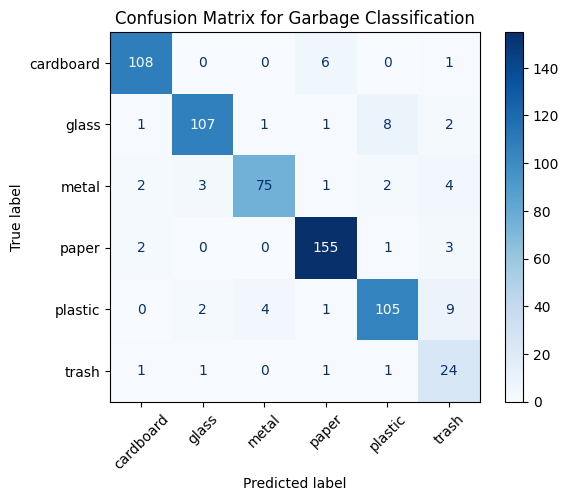

In [89]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(all_labels, all_predictions, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Garbage Classification")
plt.show()

In [90]:
torch.save(model.state_dict(), 'final_model.pth')